##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas 
#%pip install numpy
#%pip install matplotlib
#%pip install sckit-learn
#%pip install seaborn
#%pip install datetime
#%pip install mlxtend
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from datetime import date
import mlxtend
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
pd.options.display.max_rows = 10000

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Cleaning / EDA

In [45]:
train_df = pd.read_parquet(filepath)
print(train_df.shape)

(17992, 304)


In [33]:
train_df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


- remove None/NaN
- change min_occ_date and cltdob_fix format
- categorical variable to do one-hot encoding: race_desc, ctrycode_desc, clttype 

In [34]:
print(train_df['race_desc'].value_counts())
print(train_df['clttype'].value_counts())
print(train_df['stat_flag'].value_counts())

Chinese    10520
Others      1699
Malay        928
Indian       849
Name: race_desc, dtype: int64
P    14657
G     3311
C       24
Name: clttype, dtype: int64
ACTIVE     17205
LAPSED       775
MATURED       12
Name: stat_flag, dtype: int64


In [35]:
def race_encode(data):
    race_encoder = OneHotEncoder()
    race_onehotarray = race_encoder.fit_transform(data[['race_desc']]).toarray()
    races = [f'{race}' for race in race_encoder.categories_[0]]
    data[races] = race_onehotarray
    data = data.drop(columns=['race_desc', 'Others'], errors='ignore')
    return data


def clttype_encode(data):
    clttype_encoder = OneHotEncoder()
    clttype_onehotarray = clttype_encoder.fit_transform(data[['clttype']]).toarray()
    clttypes = [f'{clttype}' for clttype in clttype_encoder.categories_[0]]
    data[clttypes] = clttype_onehotarray
    data = data.drop(columns=['clttype', 'G'], errors='ignore')
    return data

def stat_encode(data):
    stat_encoder = OneHotEncoder()
    stat_onehotarray = stat_encoder.fit_transform(data[['stat_flag']]).toarray()
    stats = [f'{stat}' for stat in stat_encoder.categories_[0]]
    data[stats] = stat_onehotarray
    data = data.drop(columns=['stat_flag', 'LAPSED'], errors='ignore')
    return data

def main_encode(data):
    data = race_encode(data)
    data = clttype_encode(data)
    data = stat_encode(data)
    return data

In [36]:
def calculate_duration(past):
    today = date.today()
    return today.year - past.year - ((today.month, today.day) < (past.month, past.day))

def cleaning_dates(data):
    data['min_occ_date']= pd.to_datetime(data['min_occ_date'])
    data['min_occ_dur'] = data['min_occ_date'].apply(calculate_duration)

    data['cltdob_fix']= pd.to_datetime(data['cltdob_fix'])
    data['age'] = data['cltdob_fix'].apply(calculate_duration)

    data = data.drop(columns=['min_occ_date', 'cltdob_fix'], errors='ignore')
    return data

In [48]:
def data_cleaning(data):
    cols_to_drop = ["clntnum", "giclaim_cnt_success", "recency_giclaim_success", "giclaim_cnt_unsuccess", "recency_giclaim_unsuccess", "flg_gi_claim_29d435_ever", "flg_gi_claim_058815_ever", "flg_gi_claim_42e115_ever", "flg_gi_claim_856320_ever",
                    "flg_hlthclaim_14cb37_ever", "flg_hlthclaim_839f8a_ever", "hh_size", "hh_20", "pop_20",
                    "is_valid_dm", "is_valid_email", "is_housewife_retiree", "is_dependent_in_at_least_1_policy", "f_ever_declined_la"]
    cols2 = ["ape_gi_42e115", "ape_ltc_1280bf", "ape_inv_dcd836", "ape_lh_d0adeb", "ape_gi_a10d1b", "ape_gi_29d435", "ape_gi_058815",
                    "sumins_grp_22decf", "sumins_gi_a10d1b", "sumins_gi_29d435", "sumins_lh_e22a6a", "sumins_gi_856320", "sumins_grp_94baec", "sumins_gi_058815", "sumins_grp_e04c3a", "sumins_32c74c",
                    "prempaid_gi_42e115", "prempaid_ltc_1280bf", "prempaid_inv_dcd836", "prempaid_lh_d0adeb", "prempaid_gi_a10d1b", "prempaid_gi_29d435", "prempaid_gi_058815",
                    "ape_d0adeb", "f_hold_gi", "sumins_gi", "prempaid_d0adeb", "prempaid_gi", 'ape_gi_856320', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf', 'sumins_inv_dcd836', 'sumins_lh_d0adeb', 'prempaid_gi_856320', 'prempaid_32c74c', 'ape_gi',
                    'f_hold_d0adeb', 'sumins_e22a6a', 'sumins_d0adeb', 'lapse_ape_ltc_1280bf', 'f_ever_bought_ltc_1280bf', 'n_months_last_bought_d0adeb', 'f_ever_bought_d0adeb', 'lapse_ape_32c74c', 'lapse_ape_lh_d0adeb', 'lapse_ape_inv_dcd836',
                    'n_months_last_bought_lh_d0adeb', 'n_months_last_bought_inv_dcd836', 'n_months_last_bought_ltc_1280bf', 'f_ever_bought_32c74c', 'f_ever_bought_lh_d0adeb', 'f_ever_bought_inv_dcd836']
    data.replace(to_replace=['None'], value=np.nan, inplace=True) # convert 'None' to NA to drop if needed
    data.replace(to_replace=[None], value=np.nan, inplace=True)
    data.dropna(subset=['min_occ_date', 'cltdob_fix'], inplace=True) # drop NA since 10 and 20 rows respectively
    data["f_purchase_lh"] = np.where(data["f_purchase_lh"] == 1, 1, 0) # convert to either 0 or 1
    data = data.drop(columns=cols_to_drop, errors='ignore') 
    data = data.drop(columns=cols2, errors='ignore') # initial EDA showed None for all rows

    data.loc[data.race_desc.isnull(), 'race_desc'] = 'Others'
    data["ctrycode_desc"] = np.where(data["ctrycode_desc"] == 'Singapore', 1, 0)
    data["cltsex_fix"] = np.where(data["cltsex_fix"] == 'Female', 0, 1)
    data = data.rename(columns={'ctrycode_desc': 'flg_sg', 'cltsex_fix': 'flg_male'})
    data['flg_substandard'] = np.where(data['flg_substandard'] == 1, 1, 0)
    data['annual_income_est'] = data['annual_income_est'].replace({'C.60K-100K': 60000, 'D.30K-60K' : 30000, 'A.ABOVE200K' : 200000, 'B.100K-200K' : 100000, 'E.BELOW30K': 0})
    data['hh_size_est'] = data['hh_size_est'].replace({'>4': 4})
    
    data = main_encode(data)
    data = cleaning_dates(data)

    data.fillna(0, inplace=True)

    data = data.astype(float)
    data=(data-data.min())/(data.max()-data.min())
    data.fillna(0, inplace=True)

    return data


In [49]:
train_df = data_cleaning(train_df)
print(train_df.head)
print('Proportion of likelihood buy', train_df['f_purchase_lh'].value_counts())

<bound method NDFrame.head of        flg_sg  flg_male  flg_substandard  flg_is_borderline_standard  \
19550     1.0       0.0              0.0                         0.0   
4600      1.0       1.0              0.0                         0.0   
13337     1.0       1.0              0.0                         0.0   
15074     1.0       0.0              0.0                         0.0   
19724     1.0       0.0              0.0                         0.0   
...       ...       ...              ...                         ...   
11284     1.0       1.0              0.0                         0.0   
11964     1.0       1.0              0.0                         0.0   
5390      1.0       0.0              0.0                         0.0   
860       1.0       1.0              0.0                         0.0   
15795     1.0       1.0              0.0                         0.0   

       flg_is_revised_term  flg_is_rental_flat  flg_has_health_claim  \
19550                  0.0       

In [51]:
corr = train_df.corr().abs()

s = corr.unstack()
so = s.sort_values(kind="quicksort")
(so[-1400:-280])

sumins_839f8a                      f_ever_bought_grp_fd3bfb             0.654236
f_ever_bought_grp_fd3bfb           sumins_839f8a                        0.654236
sumins_grp_de05ae                  n_months_last_bought_grp_de05ae      0.655107
n_months_last_bought_grp_de05ae    sumins_grp_de05ae                    0.655107
f_ever_bought_lh_947b15            sumins_lh_947b15                     0.657034
sumins_lh_947b15                   f_ever_bought_lh_947b15              0.657034
n_months_last_bought_lh_947b15     sumins_lh_947b15                     0.658402
sumins_lh_947b15                   n_months_last_bought_lh_947b15       0.658402
f_ever_bought_lh_f852af            prempaid_lh_f852af                   0.659095
ape_lh_f852af                      f_ever_bought_lh_f852af              0.659095
prempaid_lh_f852af                 f_ever_bought_lh_f852af              0.659095
f_ever_bought_lh_f852af            ape_lh_f852af                        0.659095
n_months_last_bought_lh_f852

In [52]:
def remove_correlated(data):
    nmths_lapse = 'n_months_since_lapse_'
    ape = 'ape_'
    nmths_bought = 'n_months_last_bought_'
    drop_cols = []
    for i in data.columns:
        if i.startswith(nmths_lapse) or i.startswith(ape) or i.startswith(nmths_bought):
            drop_cols.append(i)
    data = data.drop(columns=drop_cols, errors='ignore')
    return data


In [53]:
train_df = remove_correlated(train_df)

In [54]:
corr = train_df.corr().abs()

s = corr.unstack()
so = s.sort_values(kind="quicksort")
print(so[-1000:-160])

lapse_ape_lh_507c37                f_ever_bought_lh_507c37              0.369945
f_ever_bought_lh_507c37            lapse_ape_lh_507c37                  0.369945
f_ever_bought_grp_e04c3a           prempaid_grp_fe5fb8                  0.370053
prempaid_grp_fe5fb8                f_ever_bought_grp_e04c3a             0.370053
hlthclaim_amt                      flg_with_preauthorisation            0.370512
flg_with_preauthorisation          hlthclaim_amt                        0.370512
f_ever_bought_grp_945b5a           f_ever_bought_grp_e91421             0.370678
f_ever_bought_grp_e91421           f_ever_bought_grp_945b5a             0.370678
sumins_grp_1581d7                  prempaid_grp_6fc3e6                  0.370983
prempaid_grp_6fc3e6                sumins_grp_1581d7                    0.370983
sumins_839f8a                      flg_affconnect_ready_to_buy_ever     0.371015
flg_affconnect_ready_to_buy_ever   sumins_839f8a                        0.371015
tot_inforce_pols            

In [58]:
from sklearn.feature_selection import mutual_info_classif

# Create mutual_info_classif object to calculate mutual information
X_train = train_df.drop(columns='f_purchase_lh')
y_train = train_df['f_purchase_lh']
MI_score = mutual_info_classif(X_train, y_train, random_state=0)

# Print the name and mutual information score of each feature
for feature in zip(train_df.columns, MI_score):
    print(feature)

('flg_sg', 0.0037138293094411967)
('flg_male', 0.000811256511131786)
('flg_substandard', 0.0)
('flg_is_borderline_standard', 0.0002015316298613623)
('flg_is_revised_term', 0.003334028669279121)
('flg_is_rental_flat', 0.001634567892980554)
('flg_has_health_claim', 0.0)
('flg_has_life_claim', 0.0)
('flg_gi_claim', 0.004834701619933046)
('flg_is_proposal', 0.001681690216096099)
('flg_with_preauthorisation', 0.001515063043390219)
('flg_is_returned_mail', 0.0)
('is_consent_to_mail', 0.0013113625573428767)
('is_consent_to_email', 0.0006802002074863811)
('is_consent_to_call', 0.0008999590295024618)
('is_consent_to_sms', 0.002069719838136086)
('is_sg_pr', 0.005618725943846048)
('is_class_1_2', 0.00407607163575352)
('hh_size_est', 0.006046848963097151)
('annual_income_est', 0.0027025210387940923)
('flg_latest_being_lapse', 0.004947696211555774)
('flg_latest_being_cancel', 0.0)
('recency_lapse', 0.01624361913846384)
('recency_cancel', 0.004010068534302524)
('tot_inforce_pols', 0.0044484334351264

In [42]:
# Import SelectKBest from Scikit-learn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Create a SelectKBest object
skb = SelectKBest(score_func=f_classif, # Set f_classif as our criteria to select features
                  k=100)                  # Select top two features based on the criteria

# Train and transform the dataset according to the SelectKBest
X_data_new = skb.fit_transform(X_train, y_train)

# Print the results
print('Number of features before feature selection: {}'.format(X_train.shape[1]))
print('Number of features after feature selection: {}'.format(X_data_new.shape[1]))

# Print the name of the selected features
for feature_list_index in skb.get_support(indices=True):
    print('- ' + train_df.columns[feature_list_index])

Number of features before feature selection: 241
Number of features after feature selection: 100
- flg_gi_claim
- flg_is_proposal
- is_consent_to_mail
- is_consent_to_call
- is_sg_pr
- is_class_1_2
- hh_size
- hh_size_est
- annual_income_est
- n_months_last_bought_products
- flg_latest_being_lapse
- recency_cancel
- tot_inforce_pols
- tot_cancel_pols
- ape_grp_945b5a
- ape_lh_839f8a
- ape_grp_caa6ff
- ape_grp_fd3bfb
- sumins_grp_945b5a
- sumins_ltc_43b9d5
- sumins_grp_9cdedf
- sumins_grp_1581d7
- sumins_grp_caa6ff
- sumins_grp_70e1dd
- sumins_lh_f852af
- prempaid_grp_945b5a
- prempaid_lh_839f8a
- prempaid_grp_caa6ff
- prempaid_grp_fd3bfb
- prempaid_lh_947b15
- ape_839f8a
- f_hold_839f8a
- f_hold_507c37
- sumins_839f8a
- sumins_507c37
- prempaid_839f8a
- n_months_since_lapse_ltc_1280bf
- n_months_since_lapse_grp_6fc3e6
- n_months_since_lapse_grp_de05ae
- n_months_since_lapse_inv_dcd836
- n_months_since_lapse_grp_945b5a
- n_months_since_lapse_grp_6a5788
- n_months_since_lapse_ltc_43b9d5


## Split into Train/Validation/Test sets & Oversampling

In [59]:
from sklearn.model_selection import train_test_split

y = train_df['f_purchase_lh']
X = train_df.drop('f_purchase_lh', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('Training data counts: ', X_train.shape)
print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of purchase likelihood  in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of purchase likelihood in testing data: \n', y_test.value_counts())

Training data counts:  (12212, 155)
Proportion of purchase likelihood in training data: 
 0.0    11742
1.0      470
Name: f_purchase_lh, dtype: int64
Validation data counts:  (3054, 155)
Proportion of purchase likelihood  in validation data: 
 0.0    2933
1.0     121
Name: f_purchase_lh, dtype: int64
Testing data counts:  (2694, 155)
Proportion of purchase likelihood in testing data: 
 0.0    2577
1.0     117
Name: f_purchase_lh, dtype: int64


In [60]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())

Proportion of purchase likelihood in training data: 
 0.0    11742
1.0    11742
Name: f_purchase_lh, dtype: int64


## Modelling

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

Accuracy on validation set: 0.77242960
True Neg: 2272 	 False Pos: 661
False Neg: 34 	 True Pos: 87
Precision on validation set: 0.11631016
Recall on validation set: 0.71900826
F1-Score on validation set: 0.20023015


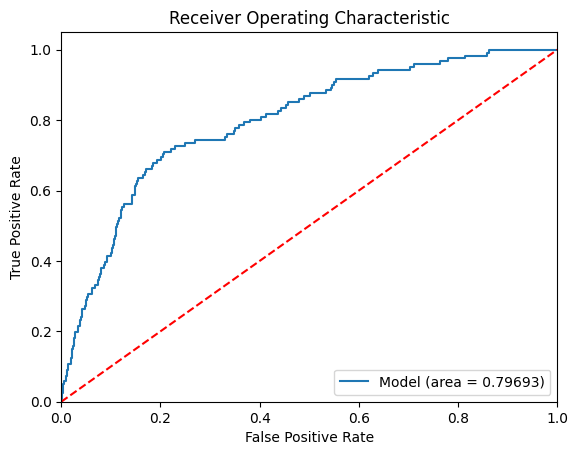

In [62]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

### Feature Selection Logistic Regression

In [57]:
# Import ExhaustiveFeatureSelector from Mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# Create a logistic regression classifier
lr = LogisticRegression()

train_acc = np.zeros(shape=(20))
valid_acc = np.zeros(shape=(20))

for i in range(1, 20):
    model = LogisticRegression(max_iter=1000)
    efs = EFS(estimator=lr,        # Use logistic regression as the classifier/estimator
          min_features=1,      # The minimum number of features to consider is 1
          max_features=i,      # The maximum number of features to consider is 4
          scoring='accuracy',  # The metric to use to evaluate the classifier is accuracy 
          cv=5
    )# Train EFS with our dataset
    efs = efs.fit(X_train, y_train)
    train_acc[i - 1]= efs.best_score_
    valid_acc[i - 1]= efs.best_score_

# Print the results
#print('Best accuracy score: %.2f' % efs.best_score_) # best_score_ shows the best score 
#print('Best subset (indices):', efs.best_idx_)       # best_idx_ shows the index of features that yield the best score 
#print('Best subset (corresponding names):', efs.best_feature_names_) # best_feature_names_ shows the feature names 
                                                                     # that yield the best score
depths = range(20)

# Plot and label the training and validation loss values
plt.plot(depths, train_acc, label='Training Accuracy')
plt.plot(depths, valid_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

Features: 241/241

In [63]:
# Import SequentialFeatureSelector from Mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Create a logistic regression classifier
lr = LogisticRegression()

# Create an SFS object
sfs = SFS(estimator=lr,       # Use logistic regression as our classifier
          k_features=(1, 10),  # Consider any feature combination between 1 and 4
          forward=True,       # Set forward to True when we want to perform SFS
          scoring='accuracy', # The metric to use to evaluate the classifier is accuracy 
          cv=5)               # The number of cross-validations to perform is 5

# Train SFS with our dataset
sfs = sfs.fit(X_train, y_train)

# Print the results
print('Best accuracy score: %.2f' % sfs.k_score_)   # k_score_ shows the best score 
print('Best subset (indices):', sfs.k_feature_idx_) # k_feature_idx_ shows the index of features 
                                                    # that yield the best score
print('Best subset (corresponding names):', sfs.k_feature_names_) # k_feature_names_ shows the feature names 
                                                                  # that yield the best score

Best accuracy score: 0.72
Best subset (indices): (9, 17, 35, 62, 85, 103, 110, 113, 115, 123)
Best subset (corresponding names): ('flg_is_proposal', 'is_class_1_2', 'sumins_grp_caa6ff', 'prempaid_lh_947b15', 'lapse_ape_lh_507c37', 'f_ever_bought_gi', 'f_ever_bought_grp_1581d7', 'f_ever_bought_lh_839f8a', 'f_ever_bought_grp_caa6ff', 'f_ever_bought_lh_f852af')


## Decision Tree

Accuracy on validation set: 0.93222004
True Neg: 2830 	 False Pos: 103
False Neg: 104 	 True Pos: 17
Precision on validation set: 0.14166667
Recall on validation set: 0.14049587
F1-Score on validation set: 0.14107884


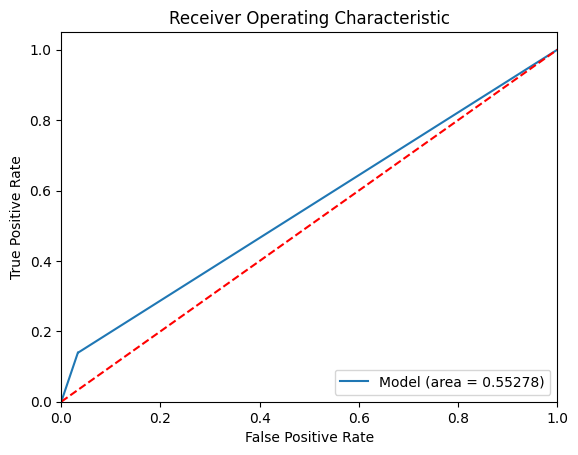

In [64]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
evaluate_model(tree, X_train, y_train, X_valid, y_valid)

### Max-Depth Decision Tree

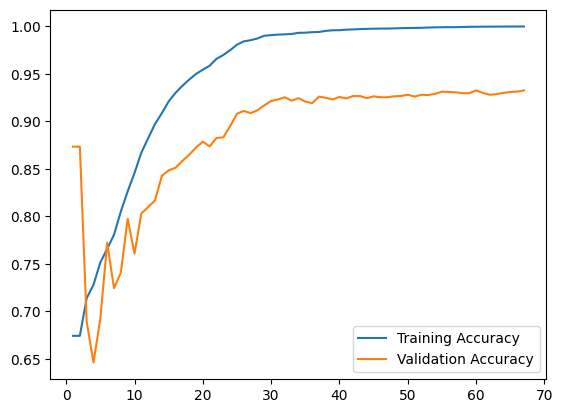

In [65]:
tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

60
Accuracy on validation set: 0.92960052
True Neg: 2820 	 False Pos: 113
False Neg: 102 	 True Pos: 19
Precision on validation set: 0.14393939
Recall on validation set: 0.15702479
F1-Score on validation set: 0.15019763


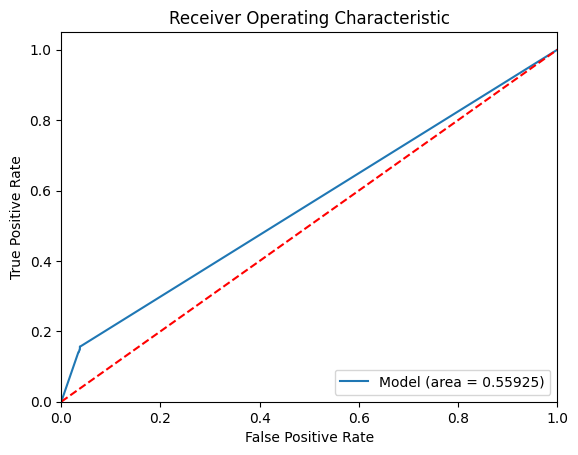

In [66]:
# max_depth = sqrt(d)
d = tree_validaccuracy.argmax(axis=0) + 1
print(d)
tree_depth = DecisionTreeClassifier(max_depth=d)
evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

Validation accuracy peaks at 60.

### Feature Selection Decision Tree

Index(['flg_male', 'flg_substandard', 'is_consent_to_mail',
       'is_consent_to_sms', 'is_sg_pr', 'is_class_1_2', 'hh_size_est',
       'annual_income_est', 'recency_lapse', 'recency_cancel',
       'tot_inforce_pols', 'sumins_ltc_43b9d5', 'sumins_grp_1581d7',
       'sumins_lh_f852af', 'prempaid_ltc_43b9d5', 'prempaid_grp_caa6ff',
       'prempaid_lh_e22a6a', 'prempaid_lh_f852af', 'sumins_839f8a',
       'sumins_ltc', 'sumins_507c37', 'prempaid_e22a6a', 'prempaid_507c37',
       'f_ever_bought_e22a6a', 'f_ever_bought_gi', 'f_retail',
       'recency_hlthclaim_14cb37', 'Chinese', 'ACTIVE', 'min_occ_dur', 'age'],
      dtype='object')
Accuracy on validation set: 0.93156516
True Neg: 2826 	 False Pos: 107
False Neg: 102 	 True Pos: 19
Precision on validation set: 0.15079365
Recall on validation set: 0.15702479
F1-Score on validation set: 0.15384615


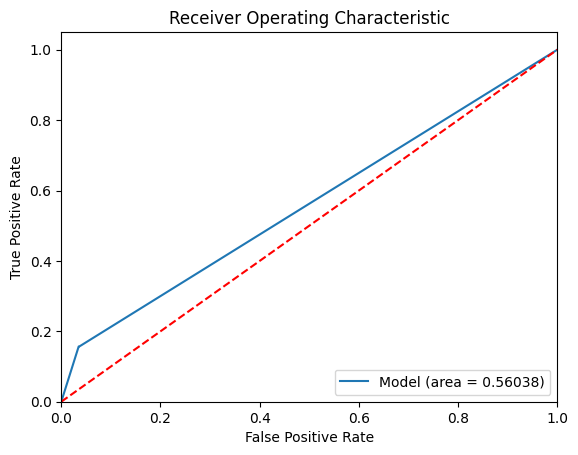

In [67]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_valid = X_valid[selected_feat]

dt_feat = DecisionTreeClassifier()
evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.95808775
True Neg: 2921 	 False Pos: 12
False Neg: 116 	 True Pos: 5
Precision on validation set: 0.29411765
Recall on validation set: 0.04132231
F1-Score on validation set: 0.07246377


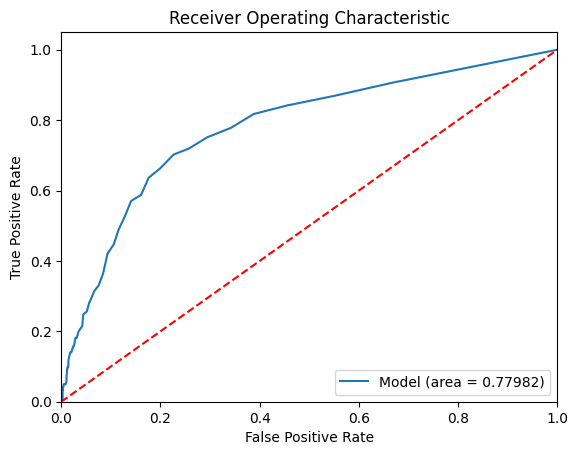

In [68]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
evaluate_model(forest, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

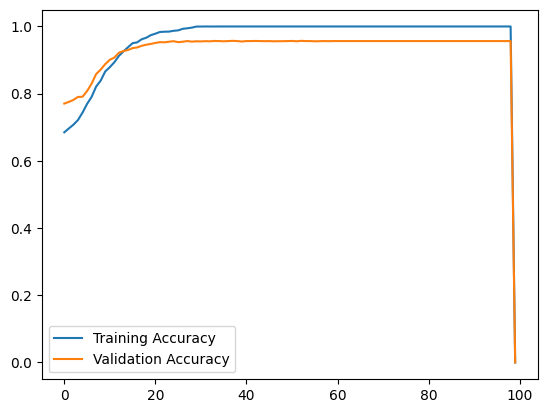

In [69]:
forest_trainaccuracy = np.zeros(shape=(100))
forest_validaccuracy = np.zeros(shape=(100))
for max_d in range(1,100):
  rf = RandomForestClassifier(max_depth=max_d, random_state=42)
  rf.fit(X_train,y_train)
  forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
  forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

depths = range(0, 100)

# Plot and label the training and validation loss values
plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

38
Accuracy on validation set: 0.95546824
True Neg: 2914 	 False Pos: 19
False Neg: 117 	 True Pos: 4
Precision on validation set: 0.17391304
Recall on validation set: 0.03305785
F1-Score on validation set: 0.05555556


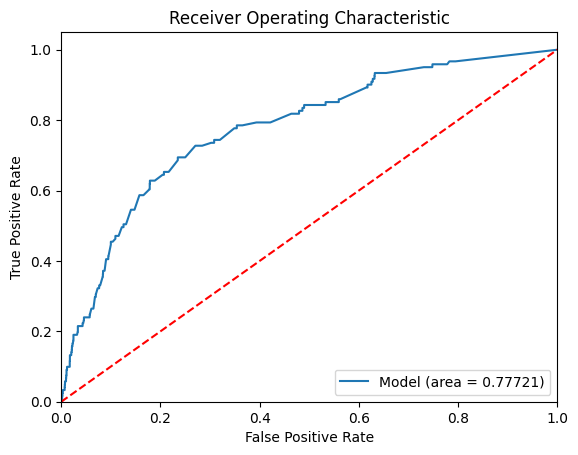

In [70]:
# max_depth = sqrt(d)
d = forest_validaccuracy.argmax(axis=0) + 1
print(d)
rf_depth = RandomForestClassifier(max_depth=d)
evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

In [ ]:
rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)
evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

In [ ]:
from numpy.random import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,7, step=1),
              'criterion':['gini','entropy'],
              'min_samples_leaf':np.arange(1,4,step=1),
              'min_samples_split':np.arange(2, 10, step=2)
          }

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   rs_space)

In [ ]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

In [ ]:
rf_rscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

Accuracy on validation set: 0.88932547
True Neg: 2685 	 False Pos: 248
False Neg: 90 	 True Pos: 31
Precision on validation set: 0.11111111
Recall on validation set: 0.25619835
F1-Score on validation set: 0.15500000


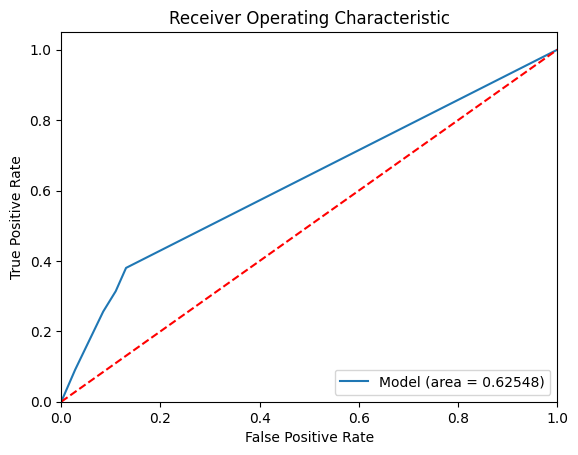

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

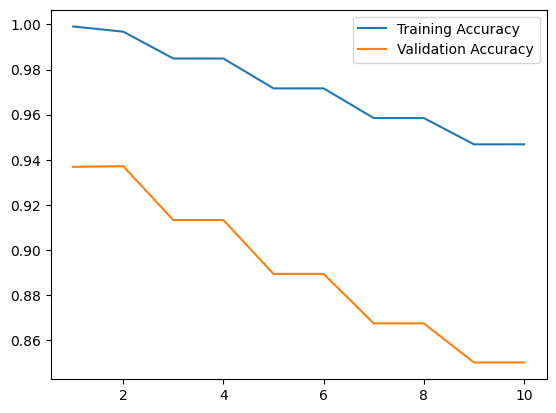

In [72]:
kn_trainaccuracy = np.zeros(10)
kn_validaccuracy = np.zeros(10)
for k in range(1,11):
  kn = KNeighborsClassifier(n_neighbors=k)
  kn.fit(X_train,y_train)
  kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
  kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

depths = range(1, 11)

# Plot and label the training and validation loss values
plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

1
Accuracy on validation set: 0.93680419
True Neg: 2850 	 False Pos: 83
False Neg: 110 	 True Pos: 11
Precision on validation set: 0.11702128
Recall on validation set: 0.09090909
F1-Score on validation set: 0.10232558


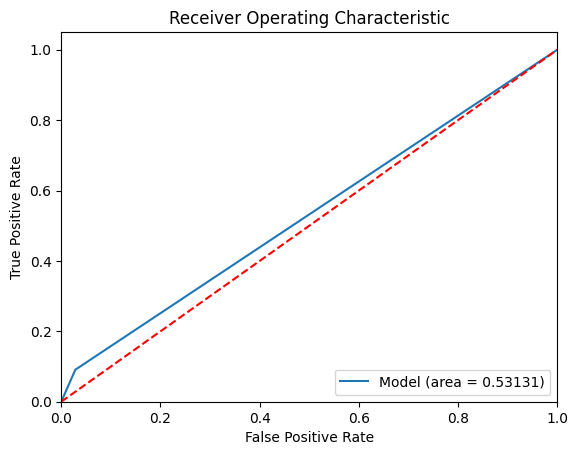

In [73]:
k = kn_validaccuracy.argmax(axis=0)
print(k)
knn_k = KNeighborsClassifier(n_neighbors=k)
evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

### KNN: feature selection

In [ ]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

sfs1 = sfs1.fit(X_train, y_train)


In [ ]:
print('Selected features:', sfs1.k_feature_idx_)
X_train_sfs = sfs1.transform(X_train)
X_valid_sfs = sfs1.transform(X_valid)
evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

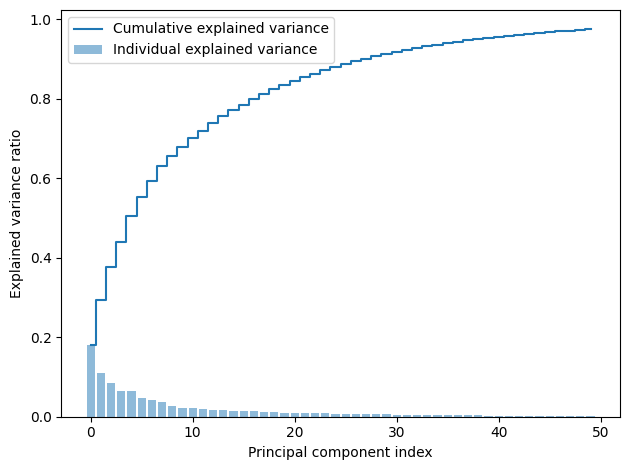

[0.18147653 0.11096265 0.08388002 0.06447891 0.06364922 0.0482132
 0.04158104 0.03591109 0.02655551 0.02265875 0.02119532 0.01957801
 0.0181267  0.01756833 0.01483701 0.01451729 0.01389693 0.01265615
 0.01221783 0.01056694 0.01041932 0.0094533  0.00904439 0.00846461
 0.00790536 0.00759691 0.00662763 0.00639044 0.00608304 0.00565908
 0.00518394 0.00500968 0.00478721 0.00450975 0.00429322 0.00423661
 0.00382836 0.00372534 0.00318436 0.00278991 0.0026556  0.00249261
 0.00241662 0.00226344 0.00206379 0.0020141  0.00190804 0.0018187
 0.00168879 0.00155435]


In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_valid)
pca_explained_variance = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(pca_explained_variance)
#
# Create the visualization plot
#
plt.bar(range(0,len(pca_explained_variance)), pca_explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(pca_explained_variance)

First component explains about 98% of the variance, second component about 1.4%

In [75]:
model_pca = PCA(n_components=9)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_valid = model_pca.transform(X_valid)

Accuracy on validation set: 0.75180092
True Neg: 2217 	 False Pos: 716
False Neg: 42 	 True Pos: 79
Precision on validation set: 0.09937107
Recall on validation set: 0.65289256
F1-Score on validation set: 0.17248908


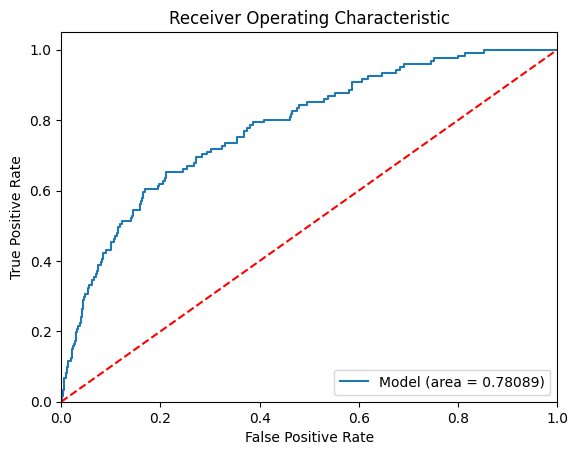

In [76]:
pca_logReg = LogisticRegression()
evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Accuracy on validation set: 0.94826457
True Neg: 2894 	 False Pos: 39
False Neg: 119 	 True Pos: 2
Precision on validation set: 0.04878049
Recall on validation set: 0.01652893
F1-Score on validation set: 0.02469136


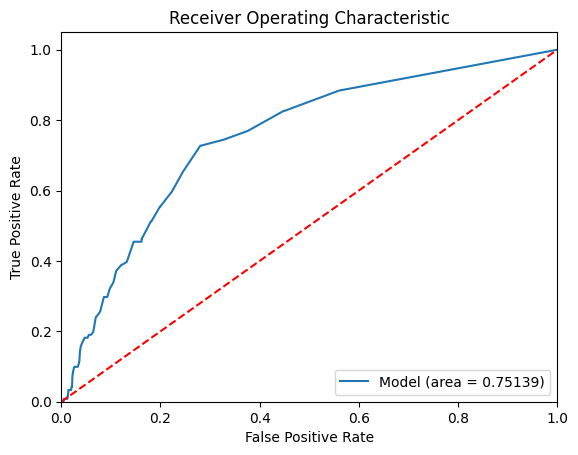

In [77]:
pca_tree = RandomForestClassifier()
evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

Accuracy on validation set: 0.88081205
True Neg: 2661 	 False Pos: 272
False Neg: 92 	 True Pos: 29
Precision on validation set: 0.09634551
Recall on validation set: 0.23966942
F1-Score on validation set: 0.13744076


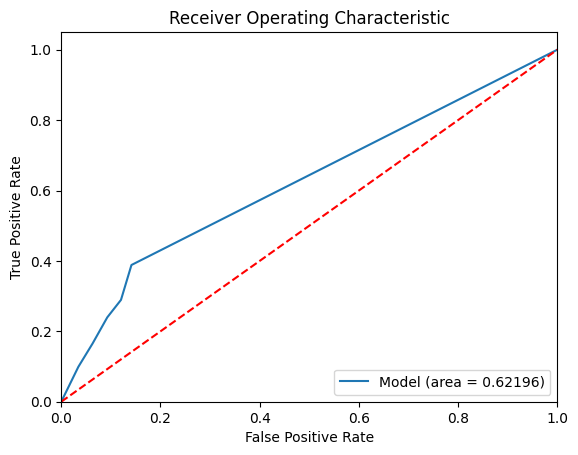

In [78]:
pca_knn = KNeighborsClassifier()
evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

Accuracy on validation set: 0.77865095
True Neg: 2297 	 False Pos: 636
False Neg: 40 	 True Pos: 81
Precision on validation set: 0.11297071
Recall on validation set: 0.66942149
F1-Score on validation set: 0.19331742


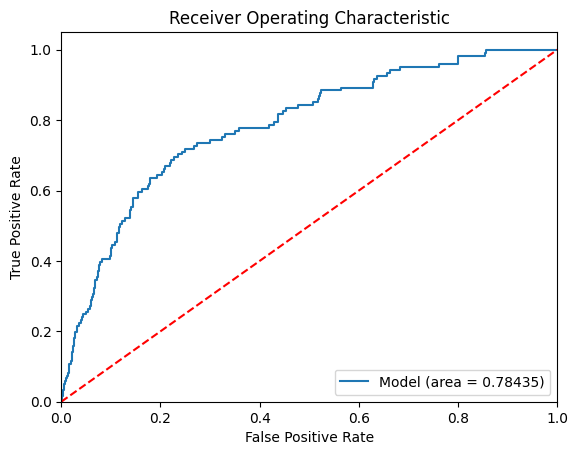

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on validation set: 0.09332024
True Neg: 173 	 False Pos: 2760
False Neg: 9 	 True Pos: 112
Precision on validation set: 0.03899721
Recall on validation set: 0.92561983
F1-Score on validation set: 0.07484130


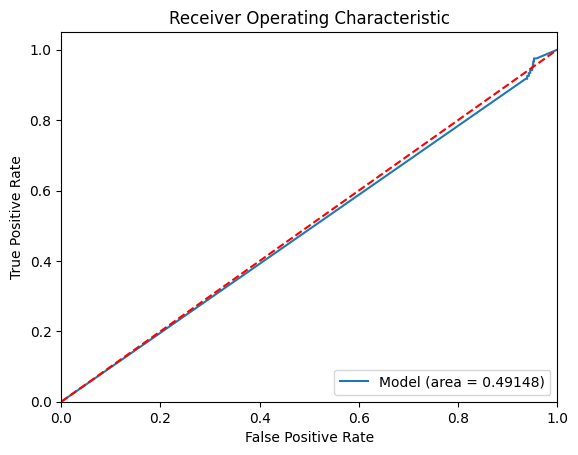

In [80]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [81]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

Precision of PLS-DA classifier on test set: 0.73
Precision of PLS-DA classifier on test set: 0.10
Recall of PLS-DA classifier on test set: 0.68


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    data = data_cleaning(hidden_data)
    data = remove_correlated(data)
    
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!